In [604]:
############################ 0. PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations
import seaborn as sns
import copy
import itertools

import tensorflow as tf
import tensorflow_lattice as tfl
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, Lambda, Layer, CategoryEncoding
from keras.constraints import Constraint
from keras.callbacks import EarlyStopping
from keras.initializers import Zeros, Constant
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.models import clone_model
import keras_tuner as kt
from keras import regularizers
from keras.utils import plot_model
from tensorflow.keras.losses import Poisson
from tensorflow.keras.losses import Loss
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras import backend as K
from scipy.stats import gamma


from pygam import LinearGAM, GAM, s, f, l
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from sklearn.tree import DecisionTreeRegressor
from interpret.glassbox import ExplainableBoostingClassifier

In [605]:
#-------------------------- for reproducibility --------------------------
seed_value = 2024
keras.utils.set_random_seed(seed_value)

In [606]:
#-------------------------- import data --------------------------
dt_low = pd.read_csv("synthetic_low_var.csv") # low variance of response
dt_high = pd.read_csv("synthetic_high_var.csv") # high variance of response
dt_low.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,0.097627,-0.215654,-0.261487,1,-0.174621,-0.793202,5,-0.373985,0.790363,0.014048,156.763152
1,0.430379,-0.917687,-0.577348,2,0.878463,-0.924689,5,-0.133907,0.381623,-0.808513,1809.221254
2,0.205527,0.846601,-0.046190,1,-0.309264,-0.659747,4,0.196131,0.513124,0.212212,457.523444
3,0.089766,-0.187530,-0.835531,0,-0.931951,0.781547,1,-0.763961,0.067880,-0.162218,88.197163
4,-0.152690,0.888564,-0.524681,1,0.045908,-0.395223,6,-0.910878,-0.748679,-0.801435,44.789407


In [607]:
#-------------------------- remove outliers - low variance --------------------------
log_claim = np.log(dt_low['Y'])
IQR = log_claim.quantile(0.75) - log_claim.quantile(0.25) # inter-quartile range
lower_whisker = log_claim.quantile(0.25)- 1.5*IQR
upper_whisker = log_claim.quantile(0.75) + 1.5*IQR

# remove outliers: filter rows where the log of 'Y' is within the whiskers
dt_low_cleaned = dt_low[(log_claim >= lower_whisker) & (log_claim <= upper_whisker)]
dt_low_cleaned

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,0.097627,-0.215654,-0.261487,1,-0.174621,-0.793202,5,-0.373985,0.790363,0.014048,156.763152
1,0.430379,-0.917687,-0.577348,2,0.878463,-0.924689,5,-0.133907,0.381623,-0.808513,1809.221254
2,0.205527,0.846601,-0.046190,1,-0.309264,-0.659747,4,0.196131,0.513124,0.212212,457.523444
3,0.089766,-0.187530,-0.835531,0,-0.931951,0.781547,1,-0.763961,0.067880,-0.162218,88.197163
4,-0.152690,0.888564,-0.524681,1,0.045908,-0.395223,6,-0.910878,-0.748679,-0.801435,44.789407
...,...,...,...,...,...,...,...,...,...,...,...
19995,0.496349,0.336766,0.766494,0,-0.906239,0.044427,4,0.539039,0.823778,0.218616,163.299665
19996,-0.403467,0.989823,-0.239838,0,-0.264332,-0.555279,1,-0.841188,-0.964766,-0.498512,803.820027
19997,-0.107088,0.176448,-0.661992,0,0.900670,0.995538,2,0.667651,-0.428700,0.324157,1507.913957
19998,-0.279747,-0.150770,-0.472139,1,0.639225,0.127594,3,0.545812,0.189384,-0.602032,835.881531


In [608]:
#-------------------------- remove outliers - high variance --------------------------
log_claim = np.log(dt_high['Y'])
IQR = log_claim.quantile(0.75) - log_claim.quantile(0.25) # inter-quartile range
lower_whisker = log_claim.quantile(0.25)- 1.5*IQR
upper_whisker = log_claim.quantile(0.75) + 1.5*IQR

# remove outliers: filter rows where the log of 'Y' is within the whiskers
dt_high_cleaned = dt_high[(log_claim >= lower_whisker) & (log_claim <= upper_whisker)]
dt_high_cleaned

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,0.097627,-0.215654,-0.261487,1,-0.174621,-0.793202,5,-0.373985,0.790363,0.014048,22.121995
1,0.430379,-0.917687,-0.577348,2,0.878463,-0.924689,5,-0.133907,0.381623,-0.808513,3166.886552
2,0.205527,0.846601,-0.046190,1,-0.309264,-0.659747,4,0.196131,0.513124,0.212212,3.606488
3,0.089766,-0.187530,-0.835531,0,-0.931951,0.781547,1,-0.763961,0.067880,-0.162218,1.415330
4,-0.152690,0.888564,-0.524681,1,0.045908,-0.395223,6,-0.910878,-0.748679,-0.801435,65.803277
...,...,...,...,...,...,...,...,...,...,...,...
19995,0.496349,0.336766,0.766494,0,-0.906239,0.044427,4,0.539039,0.823778,0.218616,63.149836
19996,-0.403467,0.989823,-0.239838,0,-0.264332,-0.555279,1,-0.841188,-0.964766,-0.498512,45861.551249
19997,-0.107088,0.176448,-0.661992,0,0.900670,0.995538,2,0.667651,-0.428700,0.324157,316.001075
19998,-0.279747,-0.150770,-0.472139,1,0.639225,0.127594,3,0.545812,0.189384,-0.602032,61.115089


In [609]:
#-------------------------- remove unimportant columns --------------------------
cat_vars = ["X4", "X7"] # categorical features
imp_vars = [f"X{index}" for index in range(1, 11)] # all important variables
# interactions = [("X5","X6"), ("X1", "X2"), ("X2", "X3")
interactions = [("X2","X3")]

# filter
dt_low_filtered = dt_low_cleaned[imp_vars]
dt_high_filtered = dt_high_cleaned[imp_vars]

In [610]:
############################ 1. MODEL FITTING ############################

#-------------------------- train-test split --------------------------
# low variance
X_main_low, X_test_low, y_main_low, y_test_low = train_test_split(
    dt_low_filtered, dt_low_cleaned[["Y"]], test_size = 0.2, random_state = 1)
X_train_low, X_val_low, y_train_low, y_val_low = train_test_split(
    X_main_low, y_main_low, test_size = 0.25, random_state = 1)

# high variance
X_main_high , X_test_high , y_main_high , y_test_high  = train_test_split(
    dt_high_filtered, dt_high_cleaned[["Y"]], test_size = 0.2, random_state = 1)
X_train_high , X_val_high , y_train_high , y_val_high  = train_test_split(
    X_main_high , y_main_high , test_size = 0.25, random_state = 1)

In [611]:
# -------------------------- function to create a subnetwork --------------------------
# subnet for numerical variables
def create_subnet(num_layers, units_per_layer, activation, model_name, dropout_rate = 0, trainable = True, seed = 1):
    model = Sequential(name = model_name)
    for _ in range(num_layers):
        model.add(Dense(units_per_layer, activation = activation, trainable = trainable))
        model.add(Dropout(dropout_rate, seed = seed))
    model.add(Dense(1, trainable = trainable))
    model.add(Lambda(lambda x: x - keras.ops.mean(x, axis = 0, keepdims = True), output_shape=(1,))) # zero center all output
    return model

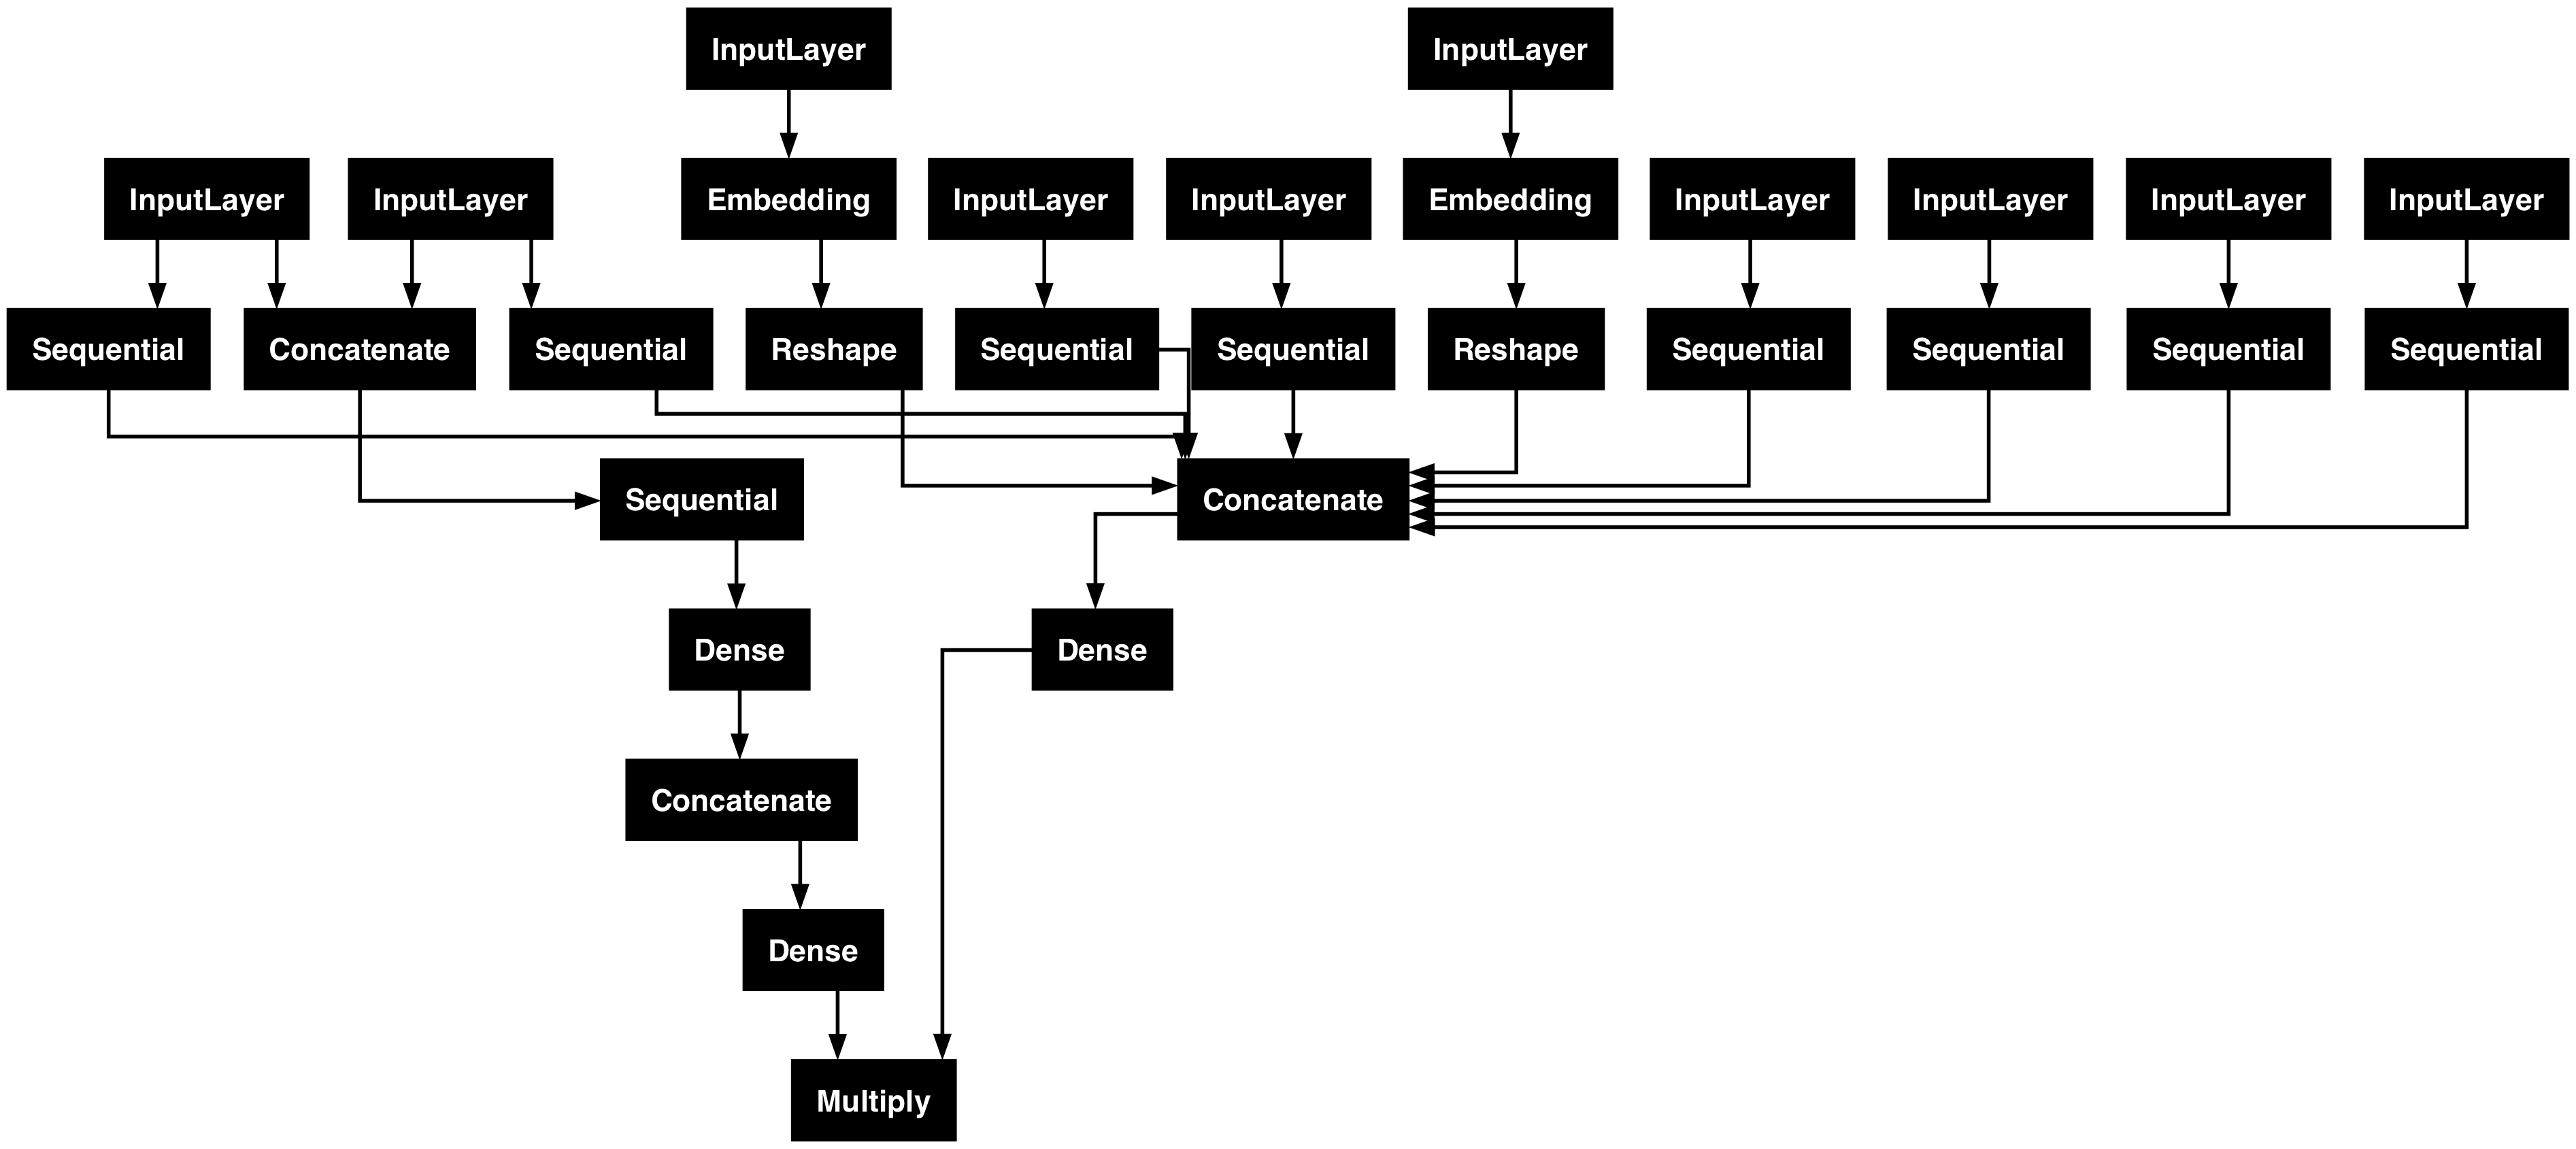

In [612]:
# -------------------------- define model architecture --------------------------
inputs = []  # input layers
sub_outputs_main = []  # main effect subnet output
sub_outputs_interaction = []  # interaction effect subnet output
num_neurons_main = 10
num_layers_main = 2
num_neurons_interaction = 200
num_layers_interaction = 15
activation = 'leaky_relu'

# main effect
for name in imp_vars:
    # Input layers
    input_layer = Input(shape = (1,), name = name)
    inputs.append(input_layer)

    # subnetworks for main effects
    if name in cat_vars: # categorical variables
        # categorical variables will be one-hot encoded
        embed_layer = Embedding(input_dim = X_train_low[name].nunique(), 
                                output_dim = 1, 
                                name = f"embed_{name}")(input_layer)
        embed_layer_reshape = Reshape(target_shape = (1,), name = f"reshape_{name}")(embed_layer)
        sub_outputs_main.append(embed_layer_reshape)
    else: # numeric variables
        subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"{name}_subnetwork")
        sub_output = subnet(input_layer)
        sub_outputs_main.append(sub_output)

# pairwise interaction effect
for (var1, var2) in interactions:
    var1_input = inputs[imp_vars.index(var1)]
    var2_input = inputs[imp_vars.index(var2)]
    pairwise_input_layer = Concatenate(name = f"{var1}_{var2}_concat")([var1_input, var2_input])
    pairwise_subnet = create_subnet(num_layers_interaction, 
                                    num_neurons_interaction, 
                                    activation, 
                                    f"{var1}_{var2}_subnetwork")
    pairwise_dense = pairwise_subnet(pairwise_input_layer)
    switcher_layer = Dense(1, use_bias = False, 
                               kernel_initializer = Constant(0), # the default is to switch off pairwise interaction 
                               trainable = False, 
                               name = f"{var1}_{var2}_switcher_layer")(pairwise_dense) # used for controlling interaction effect
    sub_outputs_interaction.append(switcher_layer)

# combine subnets' outputs
main_subnets = Concatenate(name = "main_subnet")(sub_outputs_main)
main_subnet_output = Dense(1, activation = 'exponential',
                     name = "main_output")(main_subnets)
interaction_subnets = Concatenate(name = "interaction_subnet")(sub_outputs_interaction)
interaction_subnet_output = Dense(1, activation = 'exponential',
                     name = "interaction_output")(interaction_subnets)
output_layer = Multiply(name = "final_output")([main_subnet_output, interaction_subnet_output])

# final model
model_low = Model(inputs = inputs, outputs = output_layer)
plot_model(model_low)

In [613]:
# -------------------------- define loss function --------------------------
# we will use a Gamma loss function
def gamma_log_likelihood(y_true, y_pred):
    y_pred = keras.ops.clip(y_pred, 1e-7, 1e30)
    return keras.ops.mean(y_true/y_pred - keras.ops.log(y_true/y_pred))

# create training & validation data consistent with the model architecture
X_train_low_split = []
X_val_low_split = []
for i in range(len(X_train_low.columns)):
    X_train_low_split.append(X_train_low.iloc[:, i])
    X_val_low_split.append(X_val_low.iloc[:, i])

# compile and fit
model_low.compile(optimizer = "rmsprop", loss = gamma_log_likelihood, metrics = [RootMeanSquaredError()])
es = EarlyStopping(restore_best_weights = True, patience = 10)
%time hist_main = model_low.fit(X_train_low_split, y_train_low, epochs = 5_000, \
    callbacks = [es], batch_size = 1_000, validation_data = (X_val_low_split, y_val_low))

Epoch 1/5000


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 1522.4551 - root_mean_squared_error: 5187.6846 - val_loss: 1380.7367 - val_root_mean_squared_error: 5824.3696
Epoch 2/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1293.9781 - root_mean_squared_error: 5187.6328 - val_loss: 1222.7393 - val_root_mean_squared_error: 5824.3247
Epoch 3/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1148.2534 - root_mean_squared_error: 5187.5850 - val_loss: 1090.2106 - val_root_mean_squared_error: 5824.2754
Epoch 4/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1024.7472 - root_mean_squared_error: 5187.5322 - val_loss: 970.8953 - val_root_mean_squared_error: 5824.2183
Epoch 5/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 913.5872 - root_mean_squared_error: 5187.4707 - val_loss: 861.3810 - val_root_mean_squared_error: 5824.1499
Epoch 6/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 812.2662 - root_mean_squared_error: 5187.3975 - val_loss: 760.4249 - val_root_mean_squared_error: 58

145/373 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step

373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step


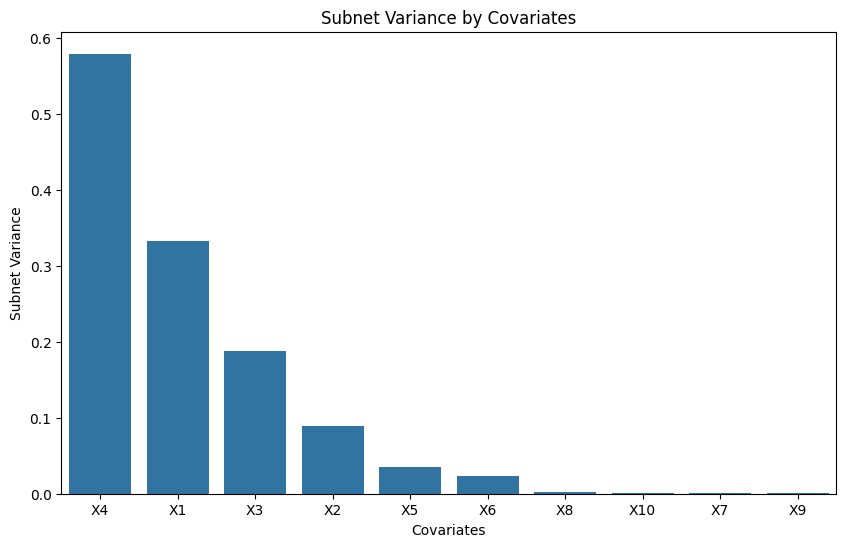

In [614]:
# -------------------------- quantify variable importance --------------------------
# Create a new model to get the output of the 'subnet_output' layer
main_output_layer = model_low.get_layer("main_subnet")  # Get the subnet output layer
main_model = Model(inputs = model_low.inputs, outputs = main_output_layer.output)
main_output_values = main_model.predict(X_train_low_split)
subnet_weights = model_low.get_layer("main_output").get_weights()[0]

# Get the variance of each subnetwork across all data points
subnet_variance = []
for i in range(main_output_values.shape[1]):
    subnet_variance.append(np.var(main_output_values[:, i])*subnet_weights[i][0]**2)

# Define covariates
covariates = [name for name in imp_vars]

# -------------------------- plot the variable importance --------------------------
# Create DataFrame for variable importance
var_importance = pd.DataFrame({"Covariates": covariates, "Subnet Variance": subnet_variance})

# Sort the DataFrame by subnet variance in decreasing order
varimp_sorted = var_importance.sort_values(by = "Subnet Variance", ascending = False)

# Create a bar plot using Seaborn
plt.figure(figsize = (10, 6))
sns.barplot(x = "Covariates", y = "Subnet Variance", data = varimp_sorted)
plt.title("Subnet Variance by Covariates")
plt.xlabel("Covariates")
plt.ylabel("Subnet Variance")
plt.show()

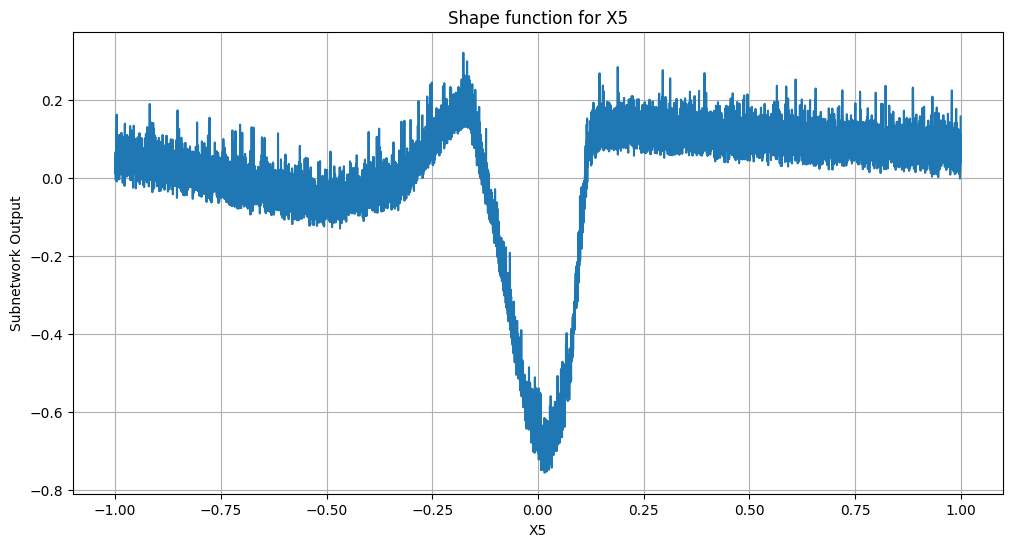

In [615]:
#-------------------------- view the shape function --------------------------
# create the plot
var_name = "X5"
var_index = imp_vars.index(var_name)
plt.figure(figsize = (12, 6))
sns.lineplot(x = X_train_low_split[var_index], y = main_output_values[:,var_index].flatten()*subnet_weights[var_index][0])
plt.xlabel(f"{var_name}")
plt.ylabel('Subnetwork Output')
plt.title(f"Shape function for {var_name}")
plt.grid(True)
plt.show()

In [616]:
#-------------------------- train the interaction effect --------------------------
global_layers = ["main_subnet", "interaction_subnet", "main_output", "interaction_output", "final_output"]# these layers are always trainable

# switch off irrelevant layers
for layer in model_low.layers:
    if layer.name not in global_layers and interactions[0][0] not in layer.name and interactions[0][1] not in layer.name:
    # if layer.name not in global_layers and "switcher_layer" not in layer.name:
        layer.trainable = False

# activate the switcher layer
switcher = model_low.get_layer(f"{interactions[0][0]}_{interactions[0][1]}_switcher_layer")
current_weights = switcher.get_weights()
new_weights = [np.ones_like(current_weights[0])] # set to 1
switcher.set_weights(new_weights)

# re-train
%time hist_interaction = model_low.fit(X_train_low_split, y_train_low, epochs = 5_000, \
    callbacks = [es], batch_size = 1_000, validation_data = (X_val_low_split, y_val_low))

Epoch 1/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.4134 - root_mean_squared_error: 4725.0659 - val_loss: 2.4317 - val_root_mean_squared_error: 5178.6694
Epoch 2/5000


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.4134 - root_mean_squared_error: 4725.4097 - val_loss: 2.4315 - val_root_mean_squared_error: 5177.6953
Epoch 3/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.4133 - root_mean_squared_error: 4725.2222 - val_loss: 2.4316 - val_root_mean_squared_error: 5178.5791
Epoch 4/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.4132 - root_mean_squared_error: 4725.1616 - val_loss: 2.4315 - val_root_mean_squared_error: 5178.1777
Epoch 5/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.4130 - root_mean_squared_error: 4725.3096 - val_loss: 2.4315 - val_root_mean_squared_error: 5179.2192
Epoch 6/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.4127 - root_mean_squared_error: 4724.8154 - val_loss: 2.4311 - val_root_mean_squared_error: 5178.0225
Epoch 7/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.4120 - root_mean_squared_error: 4723.9443 - val_loss: 2.4315 - val_root_mean_squared_error: 5178.6724
Epoch 8/5000
12/12 ━━━━

  1/373 ━━━━━━━━━━━━━━━━━━━━ 1:06 178ms/step

373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


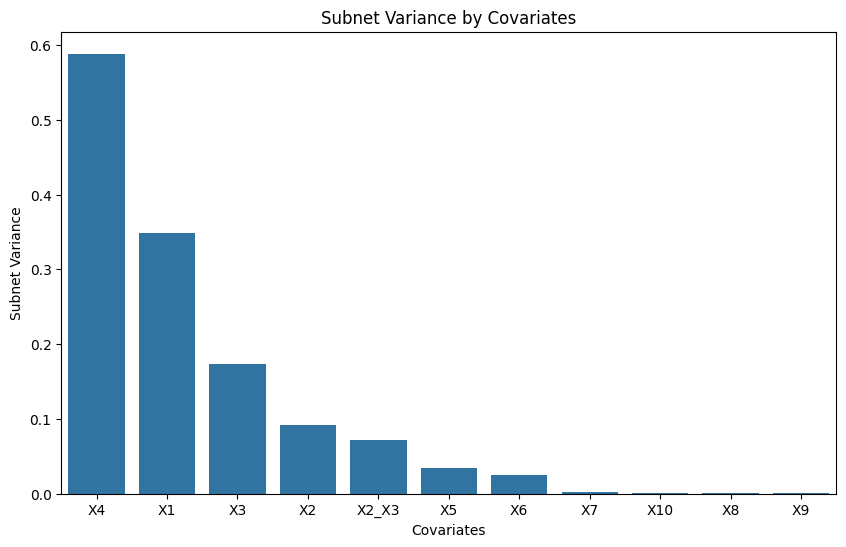

In [617]:
# -------------------------- quantify variable importance --------------------------
main_output_layer = model_low.get_layer("main_subnet")
interaction_output_layer = model_low.get_layer("interaction_subnet")
subnet_output_model = Model(inputs = model_low.inputs, outputs = [main_output_layer.output, interaction_output_layer.output])
output_values = subnet_output_model.predict(X_train_low_split)
subnet_output_values = np.concatenate((output_values[0], output_values[1]), axis = 1)
main_weights = model_low.get_layer("main_output").get_weights()[0]
interaction_weights = model_low.get_layer("interaction_output").get_weights()[0]
subnet_weights = np.concatenate((main_weights, interaction_weights), axis = 0)

# Get the variance of each subnetwork across all data points
subnet_variance = []
for i in range(subnet_output_values.shape[1]):
    subnet_variance.append(np.var(subnet_output_values[:, i])*subnet_weights[i][0]**2)

# Define covariates
covariates = [name for name in imp_vars]
for i in range(len(interactions)):
    covariates.append(f"{interactions[i][0]}_{interactions[i][1]}")

# -------------------------- plot the variable importance --------------------------
# Create DataFrame for variable importance
var_importance = pd.DataFrame({"Covariates": covariates, "Subnet Variance": subnet_variance})

# Sort the DataFrame by subnet variance in decreasing order
varimp_sorted = var_importance.sort_values(by = "Subnet Variance", ascending = False)

# Create a bar plot using Seaborn
plt.figure(figsize = (10, 6))
sns.barplot(x = "Covariates", y = "Subnet Variance", data = varimp_sorted)
plt.title("Subnet Variance by Covariates")
plt.xlabel("Covariates")
plt.ylabel("Subnet Variance")
plt.show()

 82/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


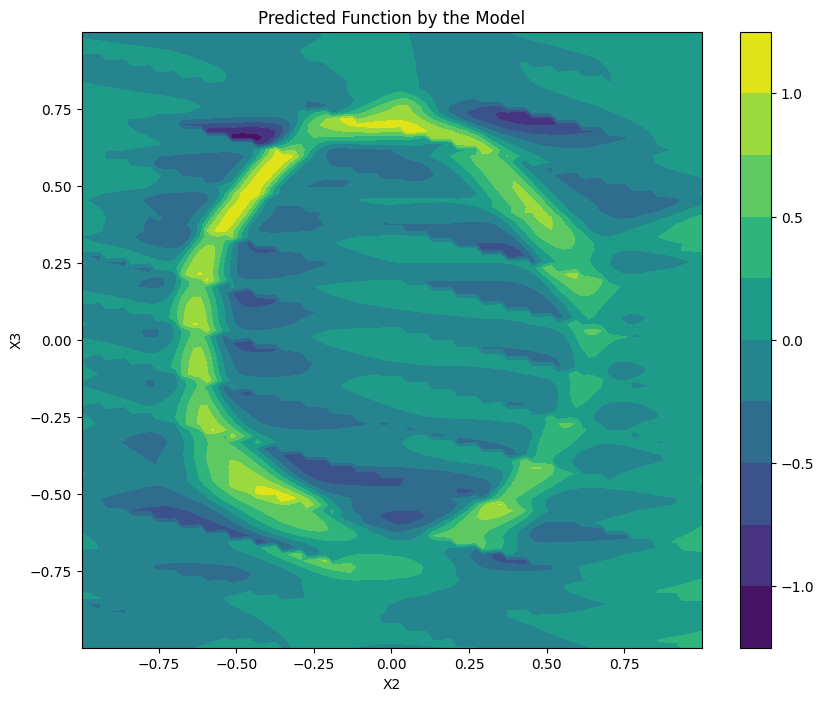

In [618]:
# -------------------------- Create the Pairwise Only Model --------------------------
pairwise_index = 0

# # Extract the pairwise inputs
# var1_input = model_low.inputs[imp_vars.index(interactions[pairwise_index][0])]
# var2_input = model_low.inputs[imp_vars.index(interactions[pairwise_index][1])]

# Create a new model with only the pairwise subnetwork as output
pairwise_output_layer = model_low.get_layer("interaction_subnet")
# pairwise_only_model = Model(inputs = [var1_input, var2_input], outputs = pairwise_output_layer.output)
pairwise_only_model = Model(inputs = model_low.inputs, outputs = pairwise_output_layer.output)
weights = model_low.get_layer("interaction_output").get_weights()[0][pairwise_index]


# -------------------------- Generate the Input Grid --------------------------
# Create a grid of values
var1_values = np.linspace(X_train_low[interactions[pairwise_index][0]].min(), 
                          X_train_low[interactions[pairwise_index][0]].max(), 
                          100)
var2_values = np.linspace(X_train_low[interactions[pairwise_index][1]].min(), 
                          X_train_low[interactions[pairwise_index][1]].max(), 
                          100)

# Create a meshgrid
grid_var1, grid_var2 = np.meshgrid(var1_values, var2_values)

# Flatten the grid
grid_flat_var1 = grid_var1.ravel()
grid_flat_var2 = grid_var2.ravel()


# -------------------------- Prepare Inputs for the Model --------------------------
# Create zero arrays for the other variables
other_vars_zero = np.zeros((len(grid_flat_var1), len(imp_vars) - 2))
grid_inputs = []
for var in imp_vars:
    if var == interactions[pairwise_index][0]:
        grid_inputs.append(grid_flat_var1)
    elif var == interactions[pairwise_index][1]:
        grid_inputs.append(grid_flat_var2)
    else:
        grid_inputs.append(np.zeros_like(grid_flat_var1))

# Convert to the format expected by the model
grid_inputs = [grid_inputs[imp_vars.index(var)] for var in imp_vars]


# -------------------------- Predict Using the Pairwise-Only Model --------------------------
# Predict the pairwise interaction effect
pairwise_predictions = pairwise_only_model.predict(grid_inputs)[:,pairwise_index]

# Reshape the predictions to the grid format
heatmap_values = pairwise_predictions.reshape(grid_var1.shape)


# -------------------------- Plot the Heatmap --------------------------
plt.figure(figsize = (10, 8))
contour = plt.contourf(grid_var1, grid_var2, heatmap_values, levels = 10)
plt.colorbar(contour)
plt.title('Predicted Function by the Model')
plt.xlabel(f"{interactions[pairwise_index][0]}")
plt.ylabel(f"{interactions[pairwise_index][1]}")
plt.show()